# Amazon Employee Access Challenge

The objective of this post is to build a model, and to learn from historical data. The model will take an employee's role information and a resource code and will return whether or not access should be granted.

In [1]:
#########################
### Environment Setup ###
#########################

import time
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
import seaborn as sns
import catboost
import catboost.datasets
import xgboost
import lightgbm as lgb
import numpy as np
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from copy import deepcopy
import pprint
import shap

In [2]:
###########
### EDA ###
###########

# load data
train_df, test_df = catboost.datasets.amazon()

print(train_df.info(),'\n')
print(test_df.info(),'\n')

for col in train_df.columns:
    print("{}: {}".format(col, len(train_df[col].unique())))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
ACTION              32769 non-null int64
RESOURCE            32769 non-null int64
MGR_ID              32769 non-null int64
ROLE_ROLLUP_1       32769 non-null int64
ROLE_ROLLUP_2       32769 non-null int64
ROLE_DEPTNAME       32769 non-null int64
ROLE_TITLE          32769 non-null int64
ROLE_FAMILY_DESC    32769 non-null int64
ROLE_FAMILY         32769 non-null int64
ROLE_CODE           32769 non-null int64
dtypes: int64(10)
memory usage: 2.5 MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58921 entries, 0 to 58920
Data columns (total 10 columns):
id                  58921 non-null int64
RESOURCE            58921 non-null int64
MGR_ID              58921 non-null int64
ROLE_ROLLUP_1       58921 non-null int64
ROLE_ROLLUP_2       58921 non-null int64
ROLE_DEPTNAME       58921 non-null int64
ROLE_TITLE          58921 non-null int64
ROLE_FAMILY_DESC    58921 non-null int6

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E43A1D6358>,
      dtype=object)

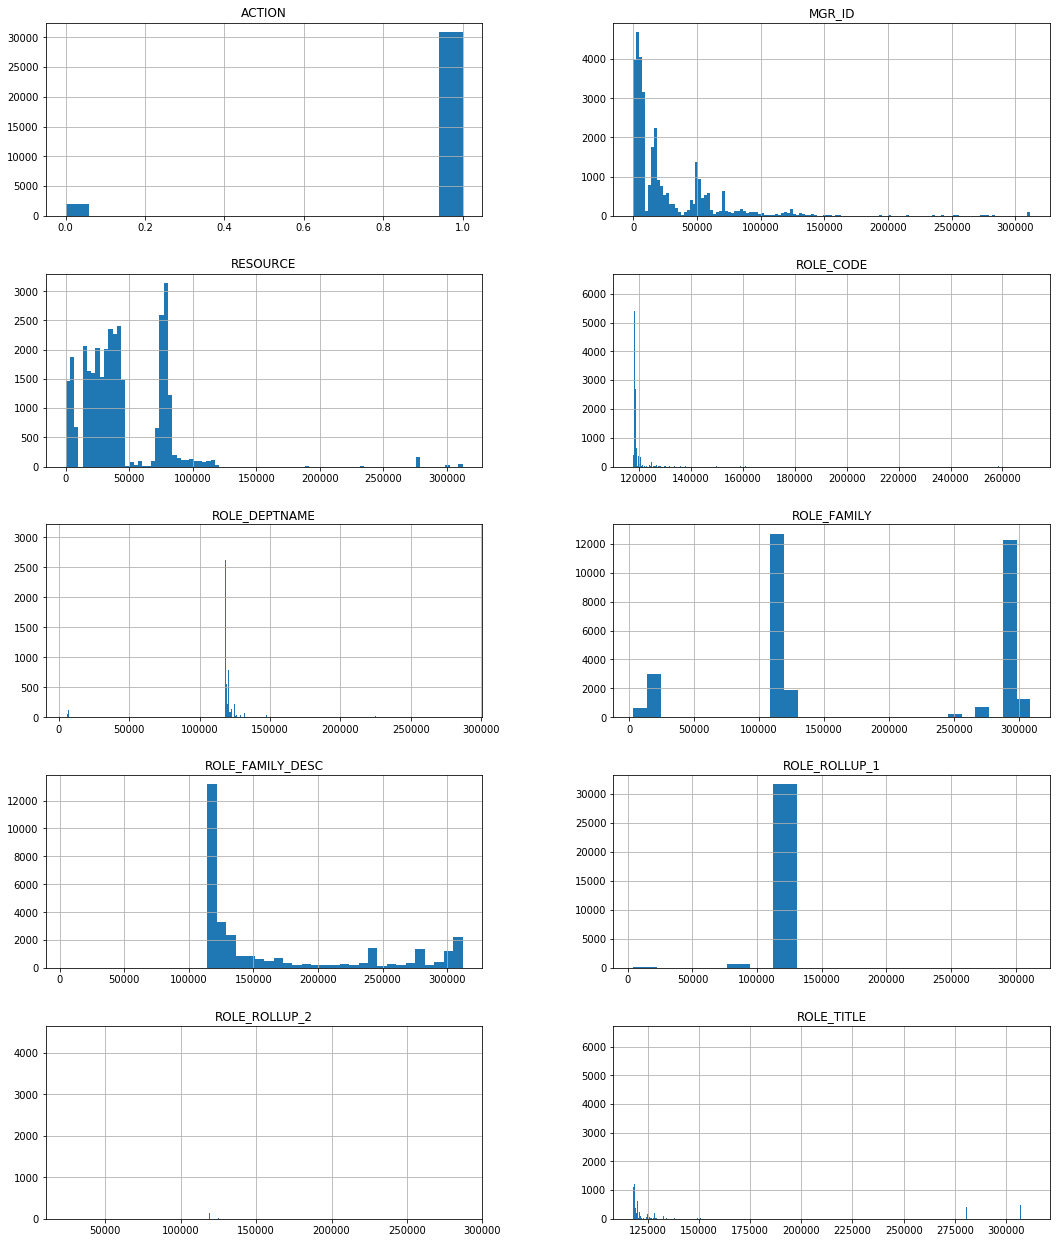

In [3]:
train_df.hist(bins='auto', figsize=(18,22), layout=(5,2))

C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value 

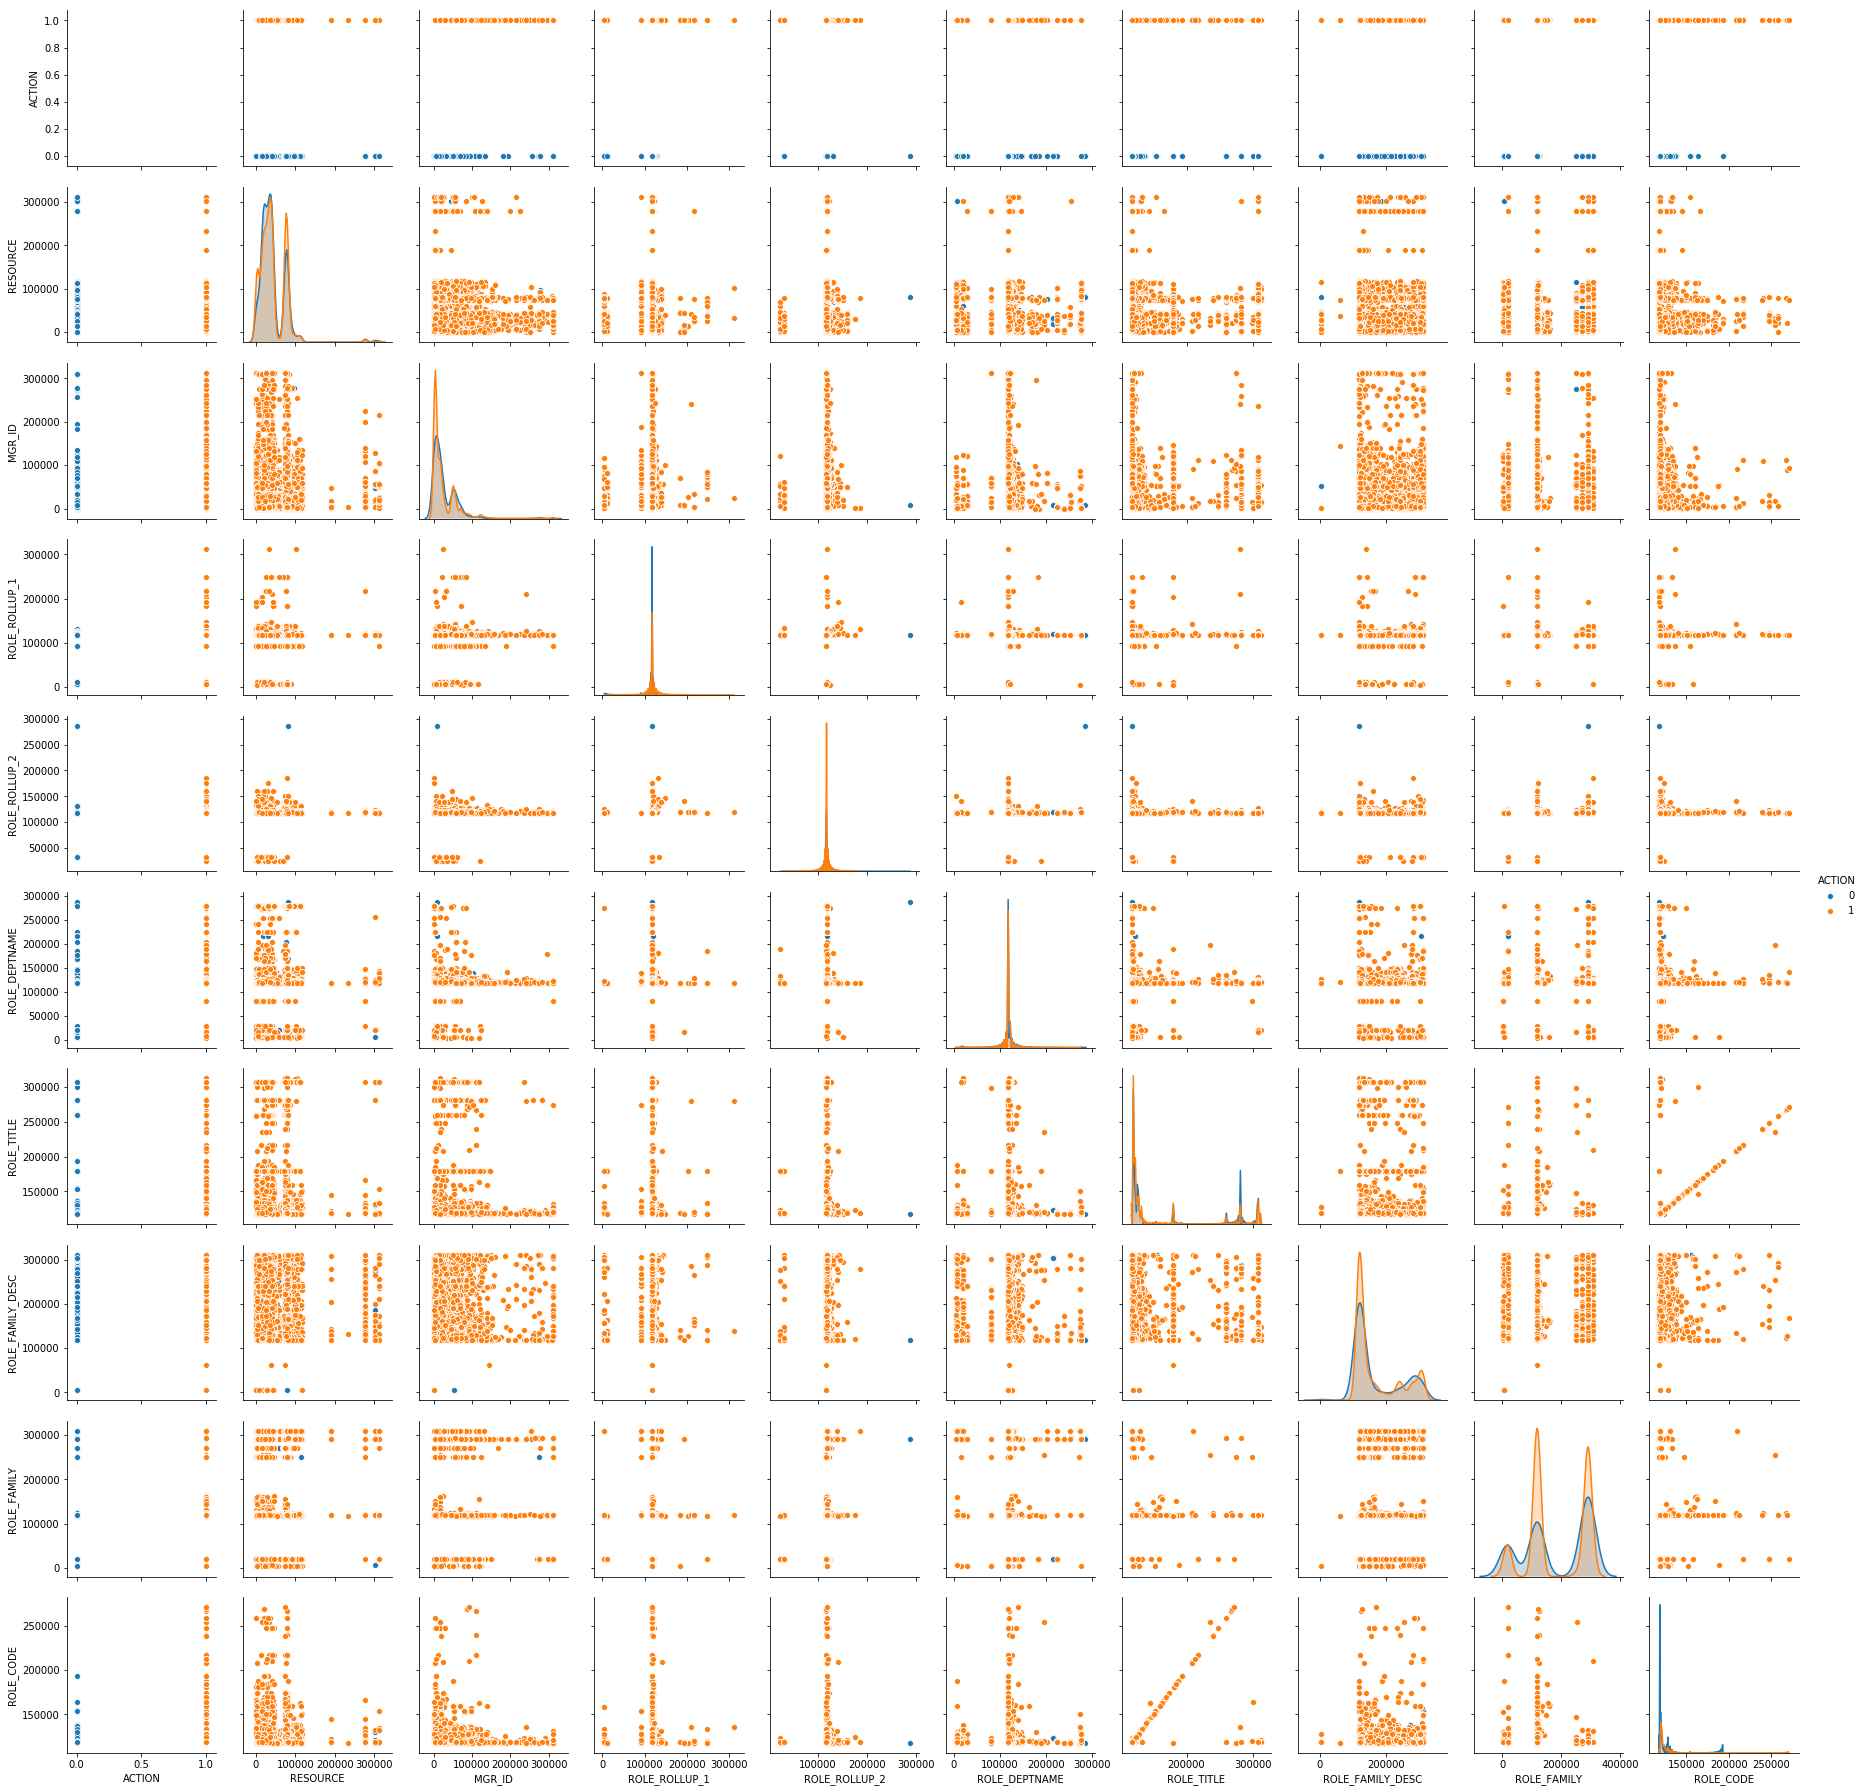

In [4]:
# target varaibles' class ratio
(train_df["ACTION"] == 1).sum() / (train_df["ACTION"] == 0).sum()   # highly unbalanced

# pair plots all subsetted by target variable
sns.pairplot(train_df, hue="ACTION")

All features are categorical. Since the categorical features have a lot of unique values, we won't use one hot encoding, but depending on the dataset it may be a good idea to adjust one_hot_max_size.

Imbalanced learning with ratio of 1:16, can use oversampling\undersampling techniques.

In [5]:
# train and test split
x = train_df.drop('ACTION', axis=1)
y = train_df['ACTION']
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=.2, stratify = y)
x_test = test_df

categorical_columns = x_train.columns
categorical_columns_indices = list(range(len(x_train.columns)))
# categorical_columns_indices = [X_train.index.get_loc(col) for categorical_columns] if not all columns are categorical

# Modeling

I will compare the following approaches:
    - XGBoost with default settings
    - XGBoost with greedy parameter tuning
    - CatBoost with default settings
    - CatBoost with greedy parameter tuning
    - LightGBM with default settings
    - LightGBM with greedy parameter tuning

In [6]:
##############################
### Optimization functions ###
##############################

# we use skopt modelue from scikit-learn library as our optimizer, but we can switch to whichever library we like as 
# our choice of optimizer.

class modelOptimizer:
    
    best_score = None   # collect the best cv results
    opt = None          # collect optimization information          
    
    def __init__(self, model, x_train, y_train, categorical_columns_indices=None, n_fold=3, seed=2045, 
                 early_stopping_rounds=30,is_stratified=True, is_shuffle=True):
        
        self.model = model   # catch whatever model we pass in
        self.x_train = x_train   # catch the train data we pass in
        self.y_train = y_train   # catch the train target we pass in
        self.categorical_columns_indices = categorical_columns_indices   # catch column index for categorical columns
        self.n_fold = n_fold   # default fold for cv is set to 3
        self.seed = seed   
        self.early_stopping_rounds = early_stopping_rounds   # prevent overfitting, default set to be 30 rounds
        self.is_stratified = is_stratified   # treatment for unbalanced target column, default set to true
        self.is_shuffle = is_shuffle   # good for experiment purpose, default set to true
    
    # function built to update the model with specified parameters
    def update_model(self, **params):
        for key, value in params.items():
            setattr(self.model, key, value)
    
    # function here doesn't do anything but to be used by other classes hence this function will be specified in other 
    # classes
    def evaluate_model(self):
        pass
    
    # function for finding the best set of params that would yeild the lowest loss value
    def optimize(self, param_space, max_evals=10, n_random_starts=2):
        
        start_time = time.time()              # record time consumed for optimization 
        
        @use_named_args(param_space)          # params used in this function is actually referring to param_space 
        def _minimize(**params):
            self.model.set_params(**params)   # substitute parameter setting to the model
            return self.evaluate_model()      # return whatever the loss value specified for the model
                                              # this loss value is the optimization objective which needs to be minimized
        
        # gp_minimize is a scikit-learn optimization modelue
        opt = gp_minimize(_minimize, param_space, n_calls=max_evals, n_random_starts=n_random_starts, random_state=2045,
                         n_jobs=-1)
        
        # collect the optimal values for all parameters
        best_values = opt.x        
        optimal_values = dict(zip([param.name for param in param_space], best_values))
        
        # collect the best cv score
        best_score = opt.fun
        self.best_score = best_score
        
        # collection optimization information
        self.opt = opt
        
        print('optimal_parameters: {}\noptimal score: {}\noptimization time: {}'.format(optimal_values, best_score, time.time()-start_time))
        print('updating model with optimal values')
        
        # update model with the optimal values
        self.update_model(**optimal_values)
        
        # produce plot used to observe loss value trend for all parameters
        plot_convergence(opt)
        
        # return optimized parameter settings
        return optimal_values

###################################
# this class can be called by the optimizer class
class xgbOptimizer(modelOptimizer):
    
    # function which the optimization function calls
    def evaluate_model(self):
        
        # cross-validation for xgboost
        scores = xgboost.cv(self.model.get_xgb_params(),   # these parameters values are from param_space
                            xgboost.DMatrix(self.x_train, label=self.y_train),
                            num_boost_round = self.model.n_estimators,
                            metrics = 'auc',   # cross-validation objective  
                            nfold = self.n_fold,
                            stratified = self.is_stratified,
                            shuffle = self.is_shuffle,
                            seed = self.seed,
                            early_stopping_rounds = self.early_stopping_rounds)   # setting for preventing overfitting
                            
        self.scores = scores              # update the cross-validated scores to the optimizer class
        test_scores = scores.iloc[:,2]    # the third column has all train scores, in this case is auc
        best_metric = test_scores.max()   # find the highest auc
    
        return 1 - best_metric            # return the loss value, this is to be used in optimization

###################################
class catOptimizer(modelOptimizer):
    
    def evaluate_model(self):
        
        validation_scores = catboost.cv(
        catboost.Pool(self.x_train, self.y_train, cat_features=self.categorical_columns_indices),
        self.model.get_params(),
        nfold=self.n_fold,
        stratified=self.is_stratified,
        seed=self.seed,
        early_stopping_rounds=self.early_stopping_rounds,
        shuffle=self.is_shuffle,
        plot=False)
        
        self.scores = validation_scores
        test_scores = validation_scores.iloc[:,2]
        best_metric = test_scores.max()
        
        return 1 - best_metric

#####################################
class lightOptimizer(modelOptimizer):
    
    def evaluate_model(self):
        
        lgb_dataset = lgb.Dataset(self.x_train, self.y_train, self.categorical_columns_indices)
        eval_hist = lgb.cv(self.model.get_params(),
                          lgb_dataset,
                          self.model.n_estimators,
                          nfold=self.n_fold,
                          seed=self.seed,
                          stratified=self.is_stratified,
                          shuffle=self.is_shuffle,
                          early_stopping_rounds=self.early_stopping_rounds,
                          metrics='auc')
        
        self.scores = eval_hist
        test_scores = eval_hist[list(eval_hist.keys())[0]]
        best_metric = max(test_scores)
        
        return 1 - best_metric

## XGBoost
### Greedy Parameter Tuning -- in Pairs

In [7]:
# Default Params 

xgb = xgboost.XGBClassifier(objective='binary:logistic', n_jobs=-1)
xgb_baseline = xgbOptimizer(xgb, x_train, y_train)
xgb_baseline.evaluate_model()

0.2628466666666668

optimal_parameters: {'learning_rate': 0.6107535672157572}
optimal score: 0.2083179999999999
optimization time: 20.97728681564331
updating model with optimal values


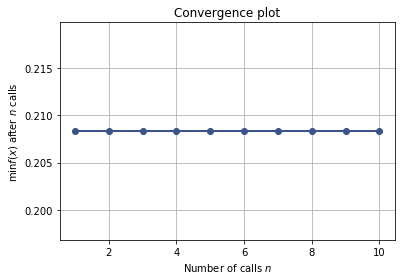

In [8]:
# Greedy Parameter Tuning -- learning rate, n_estimators

xbg = xgboost.XGBClassifier(n_estimators=10000, objective='binary:logistic', n_jobs=-1)
optimizer = xgbOptimizer(xgb, x_train, y_train)

params_space = [Real(0.01, 0.8, name='learning_rate')]
optimal_learnspeed_xgb = optimizer.optimize(params_space)

C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


optimal_parameters: {'max_depth': 23, 'min_child_weight': 10}
optimal score: 0.19251400000000007
optimization time: 39.601802587509155
updating model with optimal values


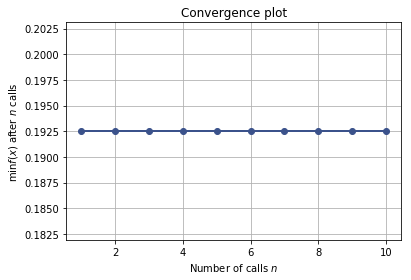

In [9]:
# Greedy Parameter Tuning -- min_child_weight, max_depth

params_space = [Integer(2, 30, name='max_depth'), Integer(1, 30, name='min_child_weight')]
optimal_treegrow_xgb = optimizer.optimize(params_space)

C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


optimal_parameters: {'subsample': 0.9978240671690879, 'colsample_bytree': 0.5052394402764596}
optimal score: 0.18546033333333334
optimization time: 38.82101273536682
updating model with optimal values


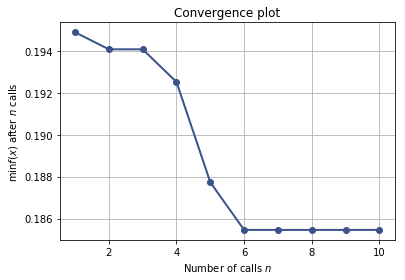

In [10]:
# Greedy Parameter Tuning -- subsample, colsample_bytree

params_space = [Real(0.5, 1.0, name='subsample'), Real(0.5, 1.0, name='colsample_bytree')]
optimal_treeflex_xgb = optimizer.optimize(params_space)

C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


optimal_parameters: {'scale_pos_weight': 16.0, 'reg_lambda': 0.0}
optimal score: 0.18296866666666667
optimization time: 37.882283210754395
updating model with optimal values


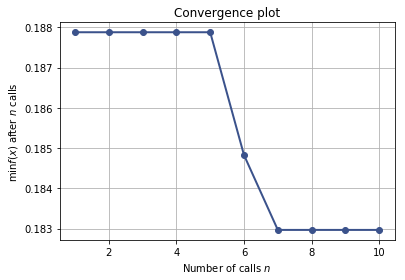

In [11]:
# Greedy Parameter Tuning -- regularization parameters

params_space = [Real(1.0, 16.0, name='scale_pos_weight'), Real(0.0, 100, name='reg_lambda')]
optimal_regularization_xgb = optimizer.optimize(params_space)

### Greedy Parameter Tuning -- One Step Optimization

optimal_parameters: {'learning_rate': 0.5490744602753704, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 1.0, 'colsample_bytree': 0.5, 'scale_pos_weight': 1.0, 'reg_lambda': 50.312214838480294}
optimal score: 0.17415266666666662
optimization time: 411.53667998313904
updating model with optimal values


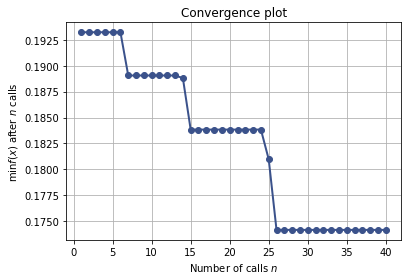

In [12]:
# Greedy Parameter Tuning -- one step optimization

xgb = xgboost.XGBClassifier(
        n_estimators=10000, # use large n_estimators deliberately to make use of the early stopping
        objective='binary:logistic',
        n_jobs=-1)

optimizer_all_xgb = xgbOptimizer(xgb, x_train, y_train)

params_space = [Real(0.01, 0.8, name='learning_rate'), 
                Integer(2, 10, name='max_depth'), 
                Integer(1, 20, name='min_child_weight'), 
                Real(0.5, 1.0, name='subsample'), 
                Real(0.5, 1.0, name='colsample_bytree'), 
                Real(1.0, 16.0, name='scale_pos_weight'), 
                Real(0.0, 100, name='reg_lambda')]

optimal_all_xgb = optimizer_all_xgb.optimize(params_space, max_evals=40)

### Model Analysis

In [13]:
# parameters tuned in one step

optimizer_all_xgb.model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.5490744602753704,
       max_delta_step=0, max_depth=10, min_child_weight=2, missing=None,
       n_estimators=10000, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=50.312214838480294, scale_pos_weight=1.0, seed=None,
       silent=True, subsample=1.0)

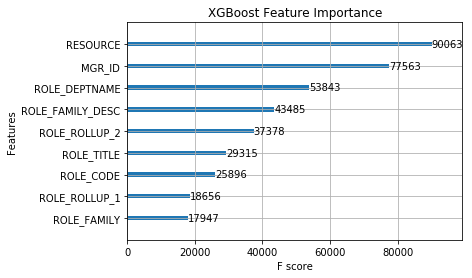

In [15]:
xgb_onestep = optimizer_all_xgb.model
xgb_onestep.fit(x_train, y_train)
xgboost.plot_importance(xgb_onestep, title='XGBoost Feature Importance')

In [14]:
# parameters tuned in several steps

optimizer.model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5052394402764596, gamma=0,
       learning_rate=0.6107535672157572, max_delta_step=0, max_depth=23,
       min_child_weight=10, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0.0, scale_pos_weight=16.0, seed=None,
       silent=True, subsample=0.9978240671690879)

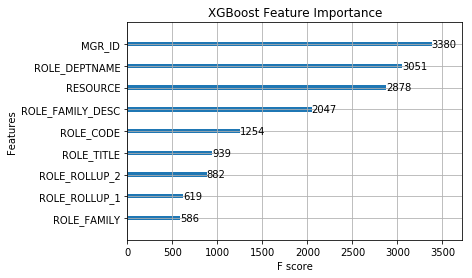

In [16]:
xgb_morestep = optimizer.model
xgb_morestep.fit(x_train, y_train)
xgboost.plot_importance(xgb_morestep, title='XGBoost Feature Importance')

## LightGBM
### Greedy Parameter Tuning -- in Pairs

In [17]:
# Default Params

lgbm = lgb.LGBMClassifier(objective='binary', n_jobs=-1)
lgbm_baseline = lightOptimizer(lgbm, x_train, y_train)
lgbm_baseline.evaluate_model()

C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:426: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:721: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


0.19244378990694122

C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:426: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:721: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:426: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:721: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constr

optimal_parameters: {'learning_rate': 0.010058448659091331}
optimal score: 0.18639337830426816
optimization time: 72.5553331375122
updating model with optimal values


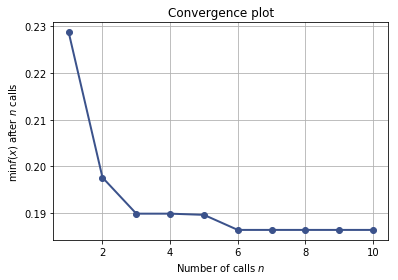

In [18]:
# Greedy Parameter Tuning -- learning rate, n_estimators

lgbm = lgb.LGBMClassifier(n_estimators=10000, objective='binary', n_jobs=-1)
optimizer = lightOptimizer(lgbm, x_train, y_train)
params_space = [Real(0.01, 0.8, name='learning_rate'),]
optimal_learnspeed_lgbm = optimizer.optimize(params_space)

C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:426: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:721: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:426: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:721: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constr

optimal_parameters: {'max_depth': 12, 'min_child_weight': 20, 'min_child_samples': 10}
optimal score: 0.18858403660114798
optimization time: 30.553107738494873
updating model with optimal values


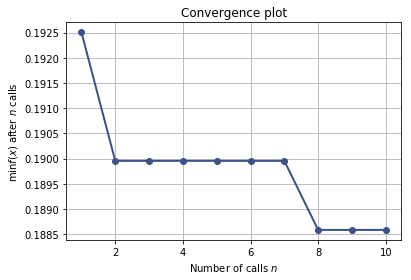

In [19]:
# Greedy Parameter Tuning -- min_child_weight, min_child_samples, max_depth

params_space = [Integer(2, 12, name='max_depth'), 
                Integer(1, 20, name='min_child_weight'), 
                Integer(10, 50, name='min_child_samples')]
optimal_treegrow_lgbm = optimizer.optimize(params_space)

C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:426: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:721: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:426: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:721: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constr

optimal_parameters: {'subsample': 0.9961925807243222, 'colsample_bytree': 0.5049657456922237}
optimal score: 0.18452144044244656
optimization time: 63.14608073234558
updating model with optimal values


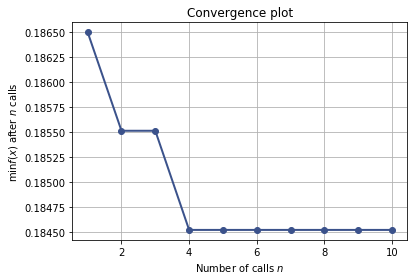

In [20]:
# Greedy Parameter Tuning -- subsample, colsample_bytree

params_space = [Real(0.5, 1.0, name='subsample'), Real(0.5, 1.0, name='colsample_bytree')]
optimal_treefelx_lgbm = optimizer.optimize(params_space)

C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:426: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:721: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:426: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:721: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constr

optimal_parameters: {'scale_pos_weight': 1.0, 'reg_lambda': 0.0}
optimal score: 0.18632248762188486
optimization time: 51.5847327709198
updating model with optimal values


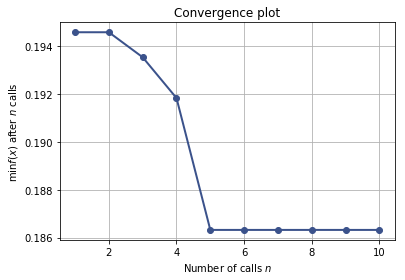

In [21]:
# Greedy Parameter Tuning -- scale_pos_weight, reg_lambda

params_space = [Real(1.0, 16.0, name='scale_pos_weight'), Real(0.0, 100, name='reg_lambda')]
optimal_regularization_lgbm = optimizer.optimize(params_space)

### Greedy Parameter Tuning -- One Step

C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:426: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:721: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:426: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:721: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constr

C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:426: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:721: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:426: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:721: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constr

C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:426: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:721: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:426: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:721: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constr

optimal_parameters: {'learning_rate': 0.2588926655949094, 'max_depth': 12, 'min_child_weight': 1, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5, 'scale_pos_weight': 1.0, 'reg_lambda': 0.0}
optimal score: 0.17670081421421402
optimization time: 327.5454876422882
updating model with optimal values


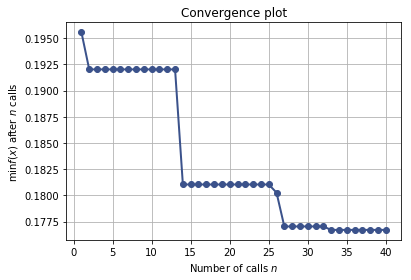

In [22]:
lgbm = lgb.LGBMClassifier(n_estimators=10000, objective='binary', n_jobs=-1)

optimizer_all_lgbm = lightOptimizer(lgbm, x_train, y_train)

params_space = [Real(0.01, 0.8, name='learning_rate'), 
                Integer(2, 12, name='max_depth'), 
                Integer(1, 20, name='min_child_weight'),
                Integer(10, 50, name='min_child_samples'),
                Real(0.5, 1.0, name='subsample'), 
                Real(0.5, 1.0, name='colsample_bytree'), 
                Real(1.0, 16.0, name='scale_pos_weight'), 
                Real(0.0, 100, name='reg_lambda')]

optimal_all_lgbm = optimizer_all_lgbm.optimize(params_space, max_evals=40, n_random_starts=4)

### Model Analysis

In [23]:
# parameters tuned in one step

optimizer_all_lgbm.model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
        importance_type='split', learning_rate=0.6233902240575574,
        max_depth=12, min_child_samples=10, min_child_weight=1,
        min_split_gain=0.0, n_estimators=10000, n_jobs=-1, num_leaves=31,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=100.0, scale_pos_weight=1.0, silent=True,
        subsample=0.7166194023620611, subsample_for_bin=200000,
        subsample_freq=0)

In [ ]:
lgbm_onestep = optimizer_all_lgbm.model
lgbm_onestep.fit(x_train, y_train)

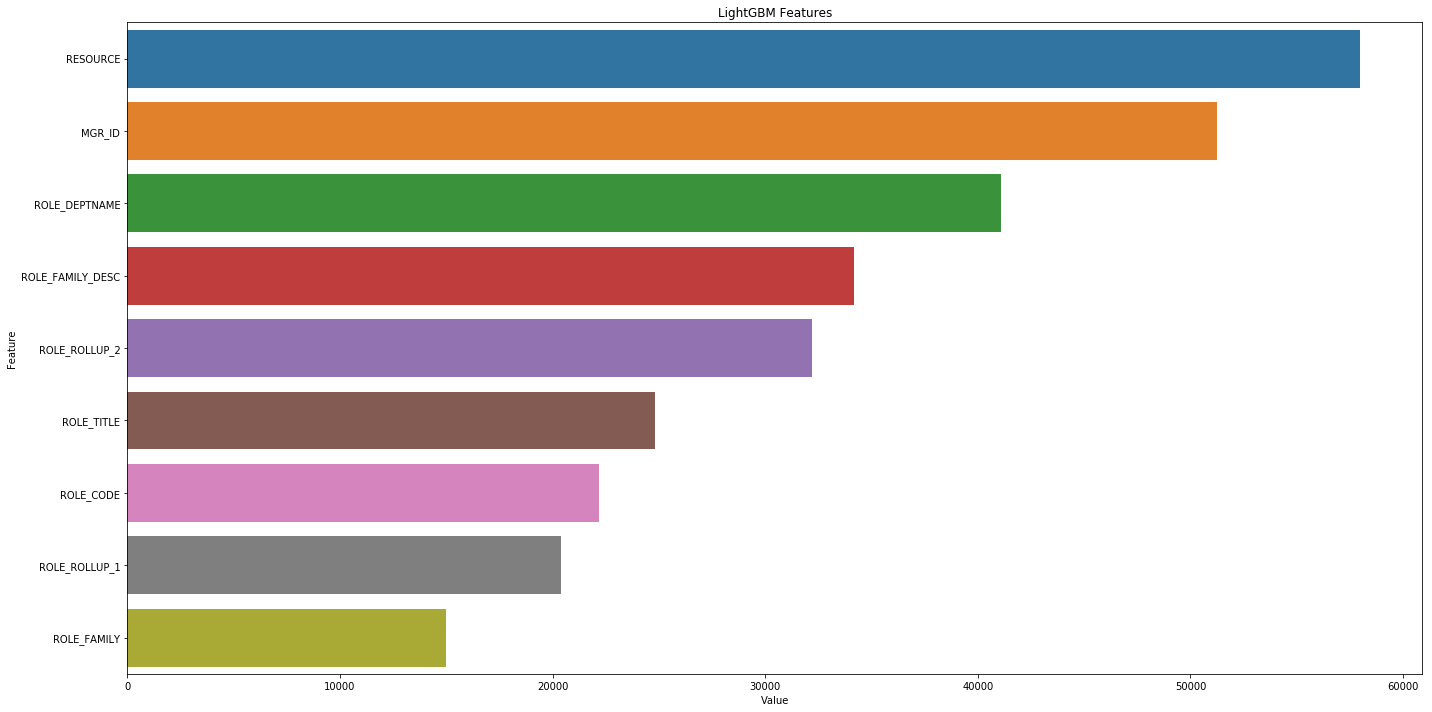

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(lgbm_onestep.feature_importances_, x_train.columns)), columns=['Value','Feature'])
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [26]:
# parameters tuned in several steps

optimizer.model

LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.9969397896165728, importance_type='split',
        learning_rate=0.17448289608473924, max_depth=9,
        min_child_samples=48, min_child_weight=20, min_split_gain=0.0,
        n_estimators=10000, n_jobs=-1, num_leaves=31, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=97.15237043425535,
        scale_pos_weight=1.081276019025815, silent=True,
        subsample=0.515908006113676, subsample_for_bin=200000,
        subsample_freq=0)

In [ ]:
lgbm_morestep = optimizer.model
lgbm_morestep.fit(x_train, y_train)

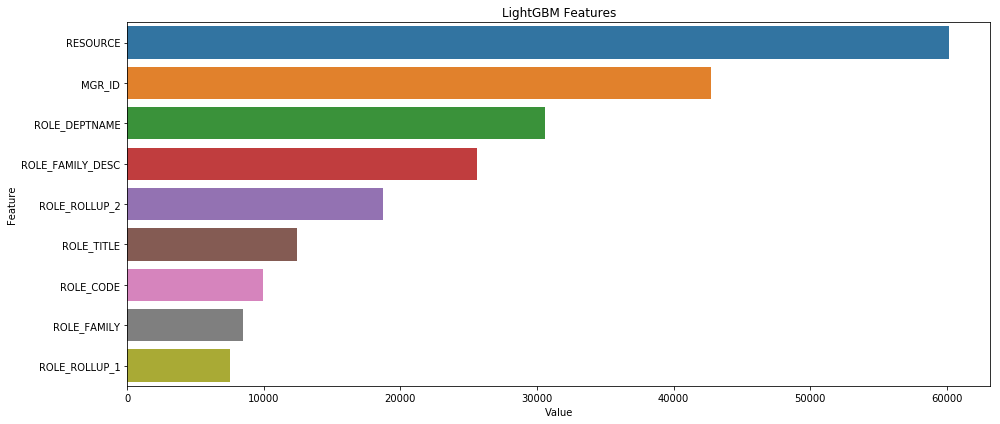

In [30]:
feature_imp = pd.DataFrame(sorted(zip(lgbm_morestep.feature_importances_, x_train.columns)), columns=['Value','Feature'])
plt.figure(figsize=(14, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

## CatBoost
### Greedy Parameter Tuning -- in Pairs

In [82]:
# Default Params - investigate the function of eval_metric parameter

catb1 = catboost.CatBoostClassifier(loss_function='Logloss', silent=True)
catb1_baseline = catOptimizer(catb1, x_train, y_train)

catb2 = catboost.CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', silent=True)
catb2_baseline = catOptimizer(catb2, x_train, y_train)

print(catb1_baseline.evaluate_model(), catb2_baseline.evaluate_model())

0.3529165217400213 0.08349255977422321


In [85]:
catb1_baseline.scores.head()

,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0.647227,0.000083,0.647083,0.000057
1,0.605798,0.000222,0.605608,0.000169
2,0.568664,0.000286,0.568404,0.000237
3,0.534287,0.000278,0.533939,0.000324
4,0.503691,0.000303,0.503296,0.000423


In [86]:
catb2_baseline.scores.head()

,test-AUC-mean,test-AUC-std,train-AUC-mean,train-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0.576521,0.013058,0.604029,0.003466,0.646909,0.000081,0.646818,0.000085
1,0.596074,0.021358,0.625487,0.005149,0.605630,0.000471,0.605517,0.000367
2,0.599772,0.013548,0.637424,0.006980,0.568306,0.000569,0.568126,0.000485
3,0.610935,0.015006,0.654811,0.005971,0.534644,0.000576,0.534375,0.000442
4,0.614108,0.013898,0.665082,0.005660,0.504430,0.000568,0.504084,0.000465


In [87]:
print(len(catb1_baseline.scores), len(catb2_baseline.scores))

1000 1000


In [89]:
# Default Params - investigate into the n_estimators parameter

catb3 = catboost.CatBoostClassifier(n_estimators=2000, loss_function='Logloss', eval_metric='AUC', silent=True)
catb3_baseline = catOptimizer(catb3, x_train, y_train)

print(catb3_baseline.evaluate_model(), len(catb3_baseline.scores))

0.08318748548446309 2000


C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


optimal_parameters: {'learning_rate': 0.7785242003302342}
optimal score: 0.04640958269393802
optimization time: 426.2331302165985
updating model with optimal values


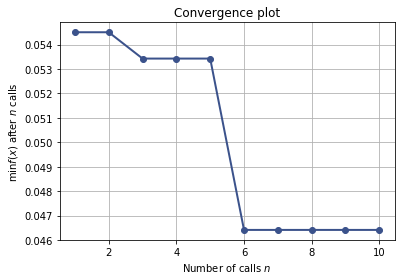

In [90]:
catb = catboost.CatBoostClassifier(n_estimators=5000, 
                                   one_hot_max_size=2,
                                   loss_function='Logloss',
                                   eval_metric='AUC',
                                   boosting_type='Ordered',
                                   random_seed=2405, 
                                   use_best_model=True,
                                   silent=True)

optimizer = catOptimizer(catb, x_train, y_train)
params_space = [Real(0.01, 0.8, name='learning_rate')]
optimal_learnspeed_catb = optimizer.optimize(params_space)

In [92]:
# use_best_model parameter seems working
# len(optimizer.scores)

# overfitting
# optimizer.scores.iloc[:,2].max()
# optimizer.scores.iloc[:,0].max()

C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


optimal_parameters: {'max_depth': 9}
optimal score: 0.011749424270906084
optimization time: 1547.6432628631592
updating model with optimal values


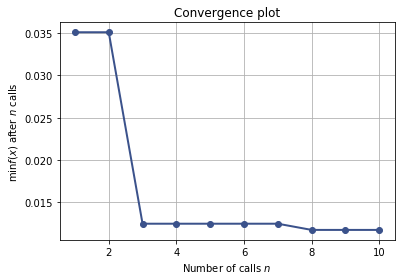

In [93]:
params_space = [Integer(2, 10, name='max_depth')]
optimal_treegrow_catb = optimizer.optimize(params_space)

optimal_parameters: {'colsample_bylevel': 0.5, 'bagging_temperature': 0.0}
optimal score: 0.03595100939243501
optimization time: 610.9687869548798
updating model with optimal values


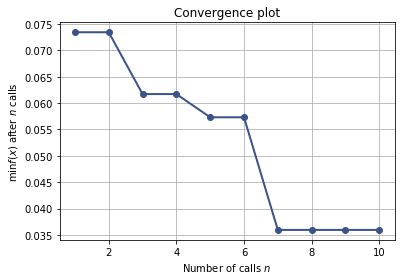

In [95]:
params_space = [Real(0.5, 1.0, name='colsample_bylevel'), 
                Real(0.0, 100, name='bagging_temperature')]
optimal_treeflex_catb = optimizer.optimize(params_space)

C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


optimal_parameters: {'random_strength': 100.0, 'reg_lambda': 1.0}
optimal score: 0.08361423781363853
optimization time: 707.4699065685272
updating model with optimal values


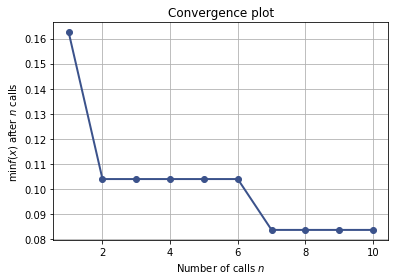

In [96]:
params_space = [Real(0.0, 100, name='random_strength'), 
                Real(1.0, 100, name='reg_lambda')]
optimal_regularization_catb = optimizer.optimize(params_space)

C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\jing.o.li\AppData\Local\Continuum\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


optimal_parameters: {'scale_pos_weight': 12.40671330156501}
optimal score: 0.0907104504367765
optimization time: 1468.4529082775116
updating model with optimal values


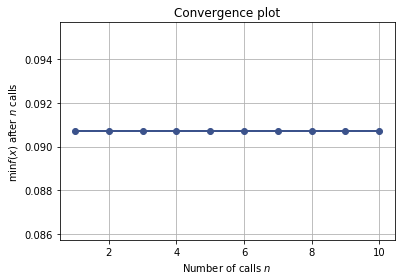

In [97]:
params_space = [Real(1.0, 16.0, name='scale_pos_weight')]
optimal_balance_catb = optimizer.optimize(params_space)

In [99]:
optimizer.model.get_params()

{'n_estimators': 5000,
 'boosting_type': 'Ordered',
 'eval_metric': 'AUC',
 'one_hot_max_size': 2,
 'silent': True,
 'use_best_model': True,
 'random_seed': 2405,
 'loss_function': 'Logloss',
 'learning_rate': 0.5211846490206036,
 'max_depth': 6,
 'colsample_bylevel': 0.5,
 'bagging_temperature': 37.75813752385265,
 'random_strength': 0.05067421131885742,
 'reg_lambda': 12.73014449950466,
 'scale_pos_weight': 1.0012113574658914}

### One Step Optimization

optimal_parameters: {'learning_rate': 0.8, 'max_depth': 10, 'colsample_bylevel': 0.5, 'scale_pos_weight': 1.0, 'bagging_temperature': 0.0, 'random_strength': 100.0, 'reg_lambda': 1.0}
optimal score: 0.011087850026662238
optimization time: 2020.3306488990784
updating model with optimal values


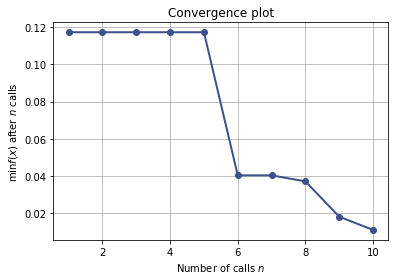

In [105]:
catb = catboost.CatBoostClassifier(n_estimators=3000, one_hot_max_size=2, loss_function='Logloss', eval_metric='AUC', 
                                   boosting_type='Ordered', random_seed=2405, use_best_model=True, silent=True)

optimizer_all_catb = catOptimizer(catb, x_train, y_train)

params_space = [Real(0.01, 0.8, name='learning_rate'), 
                Integer(2, 10, name='max_depth'), 
                Real(0.5, 1.0, name='colsample_bylevel'), 
                Real(1.0, 16.0, name='scale_pos_weight'), 
                Real(0.0, 100, name='bagging_temperature'), 
                Real(0.0, 100, name='random_strength'), 
                Real(1.0, 100, name='reg_lambda')]

optimal_all_catb = optimizer_all_catb.optimize(params_space, max_evals=10, n_random_starts=5)

In [106]:
print(optimizer_all_catb.model.get_params(), '\n')
print(optimal_all_catb)

{'n_estimators': 3000, 'boosting_type': 'Ordered', 'eval_metric': 'AUC', 'one_hot_max_size': 2, 'silent': True, 'use_best_model': True, 'random_seed': 2405, 'loss_function': 'Logloss', 'learning_rate': 0.8, 'max_depth': 10, 'colsample_bylevel': 0.5, 'scale_pos_weight': 1.0, 'bagging_temperature': 0.0, 'random_strength': 100.0, 'reg_lambda': 1.0} 

{'learning_rate': 0.8, 'max_depth': 10, 'colsample_bylevel': 0.5, 'scale_pos_weight': 1.0, 'bagging_temperature': 0.0, 'random_strength': 100.0, 'reg_lambda': 1.0}


### Model Analysis

In [110]:
catb_shap = deepcopy(optimizer_all_catb.model)
pool = catboost.Pool(x_train, y_train, cat_features=categorical_columns_indices)
catb_shap.set_params(use_best_model=False, **optimal_all_catb)
catb_shap.fit(pool, use_best_model=False)

feature_importance = catb_shap.get_feature_importance(pool, fstr_type=catboost.EFstrType.FeatureImportance, prettified=True)
interactions = catb_shap.get_feature_importance(pool, fstr_type=catboost.EFstrType.Interaction, prettified=True)
shap_values = catb_shap.get_feature_importance(pool, fstr_type=catboost.EFstrType.ShapValues)

The model has complex ctrs, so the SHAP values will be calculated approximately.


In [111]:
# feature importance

feature_importance_df = pd.DataFrame(feature_importance, columns=['feature', 'importance'])
feature_importance_df['feature'] = feature_importance_df['feature'].apply(lambda b: b.decode("utf-8"))
feature_importance_df

,feature,importance
0,ROLE_DEPTNAME,17.465278
1,RESOURCE,14.566833
2,ROLE_ROLLUP_2,13.084025
3,MGR_ID,11.716535
4,ROLE_FAMILY_DESC,11.174644
5,ROLE_FAMILY,9.424810
6,ROLE_TITLE,9.398724
7,ROLE_ROLLUP_1,7.180955
8,ROLE_CODE,5.988196


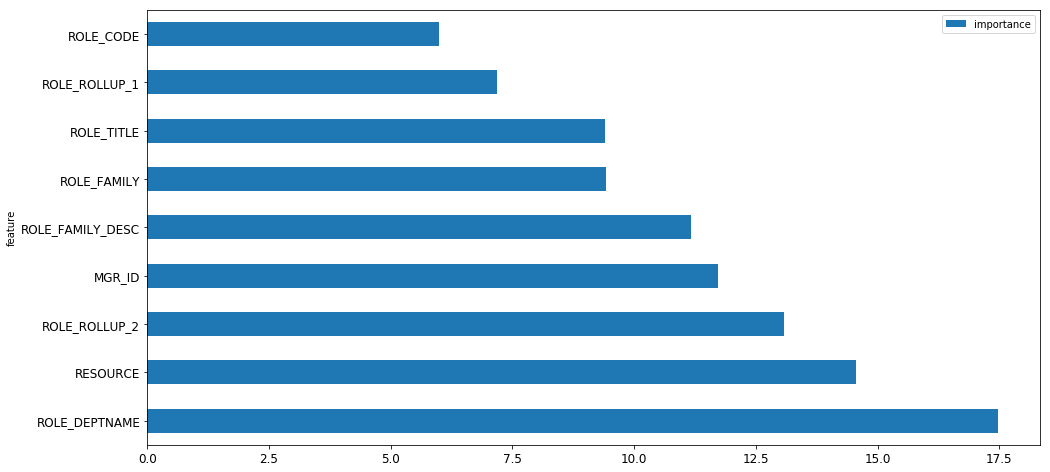

In [115]:
feature_importance_df.set_index('feature').plot(kind='barh', figsize=(16, 8), fontsize=12)

In [116]:
# feature interactions

feature_interaction = [[x_train.columns[interaction[0]], x_train.columns[interaction[1]], interaction[2]] for interaction in interactions]
feature_interaction_df = pd.DataFrame(feature_interaction, columns=['feature1', 'feature2', 'interaction_strength'])
feature_interaction_df.head(10)

,feature1,feature2,interaction_strength
0,RESOURCE,ROLE_DEPTNAME,5.296175
1,MGR_ID,ROLE_DEPTNAME,4.946643
2,MGR_ID,ROLE_ROLLUP_2,4.286478
3,MGR_ID,ROLE_FAMILY_DESC,4.272477
4,ROLE_ROLLUP_1,ROLE_DEPTNAME,4.056482
5,RESOURCE,ROLE_FAMILY,3.626309
6,MGR_ID,ROLE_TITLE,3.615853
7,RESOURCE,ROLE_ROLLUP_2,3.490575
8,ROLE_ROLLUP_2,ROLE_DEPTNAME,3.390553
9,ROLE_ROLLUP_1,ROLE_FAMILY_DESC,3.132143


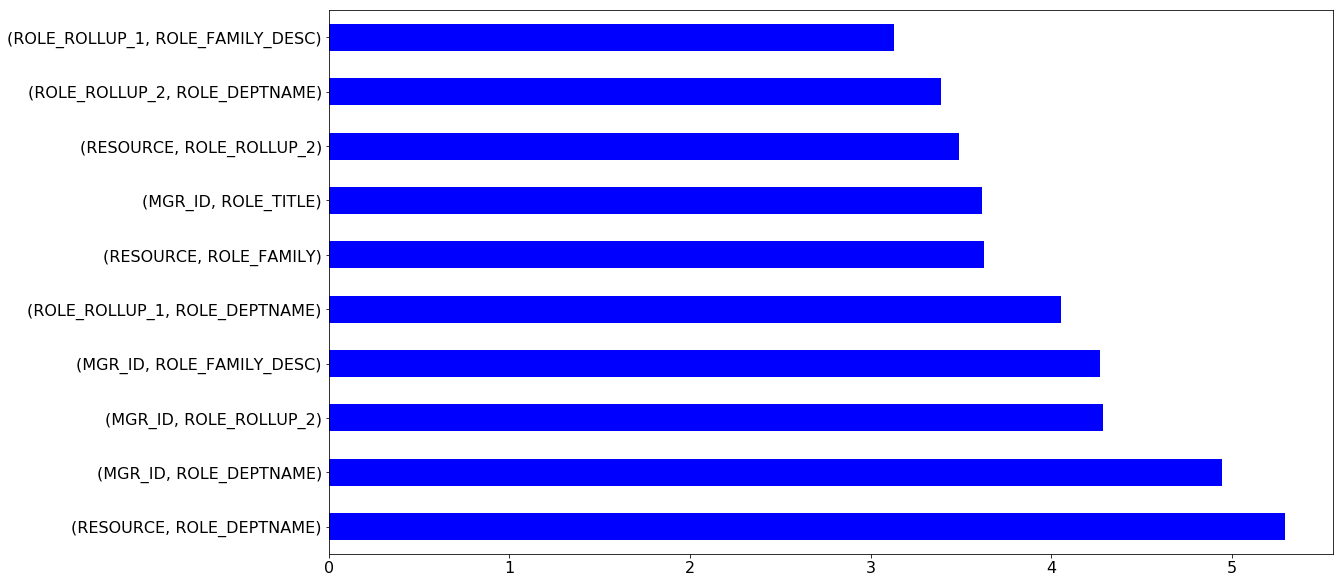

In [117]:
pd.Series(index=zip(feature_interaction_df['feature1'], feature_interaction_df['feature2']), 
          data=feature_interaction_df['interaction_strength'].values, 
          name='interaction_strength').head(10).plot(kind='barh', figsize=(18, 10), fontsize=16, color='b')

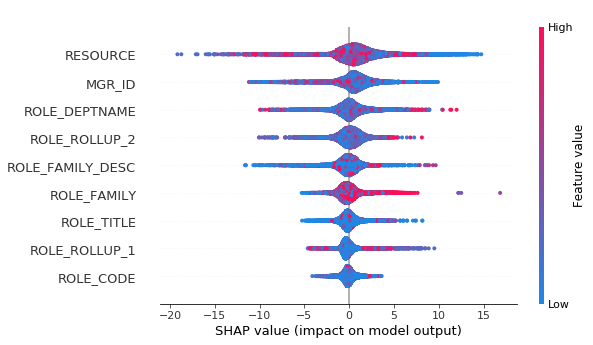

In [118]:
# SHAP values

shap.initjs()
shap.summary_plot(shap_values[:, :-1], x_train, feature_names=x_train.columns.tolist())

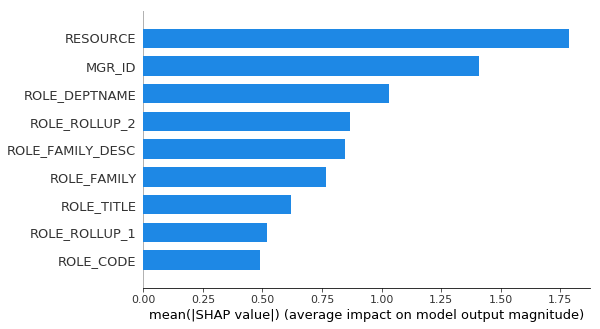

In [119]:
shap.summary_plot(shap_values[:, :-1], x_train, feature_names=x_train.columns.tolist(), plot_type="bar")

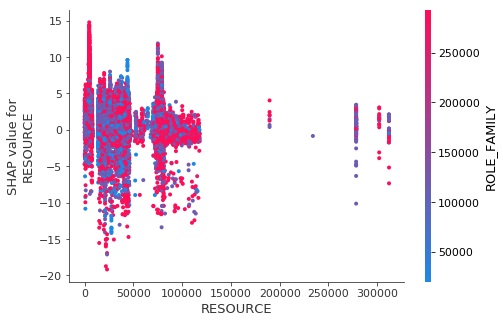

In [120]:
shap.dependence_plot("RESOURCE", shap_values[:, :-1], x_train)

In [ ]:
# The effect of objects from the training dataset on the optimized metric values for the objects from 
# the validation dataset

# indices, scores = clf.get_object_importance(
#     pool,
#     pool,
#     top_size=10,
#     ostr_type='Average',
#     update_method='SinglePoint',
#     thread_count=-1)

# object_strength_df = X_train.loc[indices, :]
# object_strength_df['strength'] = scores
# object_strength_df

# strength_s = object_strength_df.loc[:, ['strength']]
# strength_s.index.name = 'index'
# strength_s